#**AAKASH DESHMANE**
# UIN : 133008022
## ECEN 743 ASSIGNMENT 5
## POLICY GRADIENT IMPLEMENTATION OF MOUNTAIN CAR CONTINUOUS

### This is another training curve I got for Q4 when I ran it for 900 iterations. It is actually better than 800 iterations



In [1]:
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 28.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce t

In [2]:

import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import math
from collections import deque
import matplotlib.pyplot as plt


In [3]:
class value_network(nn.Module):
	'''
	Value Network: Designed to take in state as input and give value as output
	Used as a baseline in Policy Gradient (PG) algorithms
	'''
	def __init__(self,state_dim):
		'''
			state_dim (int): state dimenssion
		'''
		super(value_network, self).__init__()
		self.l1 = nn.Linear(state_dim, 128)
		self.l2 = nn.Linear(128, 64)
		self.l3 = nn.Linear(64, 1)

	def forward(self,state):
		'''
		Input: State
		Output: Value of state
		'''
		v = F.tanh(self.l1(state))
		v = F.tanh(self.l2(v))
		return self.l3(v)

In [4]:
class policy_network(nn.Module):
	'''
	Policy Network: Designed for continous action space, where given a 
	state, the network outputs the mean and standard deviation of the action
	'''
	def __init__(self,state_dim,action_dim,log_std = 0.0):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
			log_std (float): log of standard deviation (std)
		"""
		super(policy_network, self).__init__()
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.l1 = nn.Linear(state_dim,64)
		self.l2 = nn.Linear(64,64)
		#self.l3 = nn.Linear(64,64)
		#self.l4 = nn.Linear(64,64)
		self.mean = nn.Linear(64,action_dim)
		self.log_std = nn.Parameter(torch.ones(1, action_dim) * log_std)
		
	
	def forward(self,state):
		'''
		Input: State
		Output: Mean, log_std and std of action
		'''
		a = F.tanh(self.l1(state))
		a = F.tanh(self.l2(a))
		a_mean = self.mean(a)
		a_log_std = self.log_std.expand_as(a_mean)
		a_std = torch.exp(a_log_std)		
		return a_mean, a_log_std, a_std

	def select_action(self, state):
		'''
		Input: State
		Output: Sample drawn from a normal disribution with mean and std
		'''

		
		a_mean, _, a_std = self.forward(state)
		action = torch.normal(a_mean)
		return action
	
	def get_log_prob(self, state, action):
		'''
		Input: State, Action
		Output: log probabilities
		'''
		mean, log_std, std = self.forward(state)
		var = std.pow(2)
		log_density = -(action - mean).pow(2) / (2 * var) - 0.5 * math.log(2 * math.pi) - log_std
		return log_density.sum(1, keepdim=True)

In [12]:
class PGAgent():
	'''
	An agent that performs different variants of the PG algorithm
	'''
	def __init__(self,
	 state_dim, 
	 action_dim,
	 discount=0.99,
	 lr=1e-3,
	 gpu_index=0,
	 seed=0,
	 env="LunarLander-v2"
	 ):
		"""
			state_size (int): dimension of each state
			action_size (int): dimension of each action
			discount (float): discount factor
			lr (float): learning rate
			gpu_index (int): GPU used for training
			seed (int): Seed of simulation
			env (str): Name of environment
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.discount = discount
		self.lr = lr
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')
		self.env_name = env
		self.seed = seed
		self.policy = policy_network(state_dim,action_dim)
		self.value = value_network(state_dim)
		self.optimizer_policy = torch.optim.Adam(self.policy.parameters(), lr=self.lr)
		self.optimizer_value = torch.optim.Adam(self.value.parameters(), lr=self.lr)

	def sample_traj(self,batch_size=4000,evaluate = False):
		'''
		Input: 
			batch_size: minimum batch size needed for update
			evaluate: flag to be set during evaluation
		Output:
			states, actions, rewards,not_dones, episodic reward 	
		'''
		self.policy.to("cpu") #Move network to CPU for sampling
		env = gym.make(self.env_name)
		states = []
		actions = []
		rewards = []
		n_dones = []
		curr_reward_list = []
		while len(states) < batch_size:
			state, _ = env.reset(seed=self.seed)
			curr_reward = 0
			for t in range(1500):
				state_ten = torch.from_numpy(state).float().unsqueeze(0)
				with torch.no_grad():
					if evaluate:
						action = self.policy(state_ten)[0][0].numpy() # Take mean action during evaluation
					else:
						action = self.policy.select_action(state_ten)[0].numpy() # Sample from distribution during training
				action = action.astype(np.float32)
				n_state,reward,terminated,truncated,_ = env.step(action) # Execute action in the environment
				done = terminated or truncated
				states.append(state)
				actions.append(action)
				rewards.append(reward)
				n_done = 0 if done else 1
				n_dones.append(n_done)
				state = n_state
				curr_reward += reward
				if done:
					break
			curr_reward_list.append(curr_reward)
		if evaluate:
			return np.mean(curr_reward_list)
		return states,actions,rewards,n_dones, np.mean(curr_reward_list)
	



	def update(self,states,actions,rewards,n_dones,update_type='Baseline'):

		self.policy.to(self.device) #Move policy to GPU
		if update_type == "Baseline":
			self.value.to(self.device)	#Move value to GPU
		states_ten = torch.from_numpy(np.stack(states)).to(self.device)   #Convert to tensor and move to GPU
		action_ten = torch.from_numpy(np.stack(actions)).to(self.device)  #Convert to tensor and move to GPU
		rewards_ten = torch.from_numpy(np.stack(rewards)).to(self.device) #Convert to tensor and move to GPU
		n_dones_ten = torch.from_numpy(np.stack(n_dones)).to(self.device) #Convert to tensor and move to GPU

		
		if update_type == "Rt":

			rt = torch.zeros(rewards_ten.shape[0],1).to(self.device)
			rt_accum = 0
			for t in reversed(range(rewards_ten.shape[0])):
					rt_accum = rewards_ten[t] + rt_accum * self.discount *n_dones_ten[t]
					rt[t] = rt_accum

			log_prob = self.policy.get_log_prob(states_ten, action_ten)
			policy_loss = -(log_prob * rt.detach()).mean()

			self.optimizer_policy.zero_grad()
			policy_loss.backward()
			self.optimizer_policy.step()

		if update_type == 'Gt':
			gt = torch.zeros(rewards_ten.shape[0],1).to(self.device)
			g = 0
			for i in reversed(range(rewards_ten.size(0))):
				g = rewards_ten[i] + self.discount * g *(n_dones_ten[i])
				gt[i] = g

			gt = (gt - gt.mean()) / gt.std() #Helps with learning stablity
			log_prob = self.policy.get_log_prob(states_ten, action_ten)
			policy_loss = -(log_prob * gt.detach()).mean()

			self.optimizer_policy.zero_grad()
			policy_loss.backward()
			self.optimizer_policy.step()

		if update_type == 'Gt_with_Baseline':
			state_t = torch.FloatTensor(states).to(self.device)
        
			with torch.no_grad():
					self.value.to(self.device)
					values_adv = self.value(states_ten).to(self.device)
			gt = torch.zeros(rewards_ten.shape[0],1).to(self.device)
			g=0
			# STEP 2 :Compute reward-to-go (gt) and advantages
			returns = torch.zeros((rewards_ten.shape[0], 1)).to(self.device)
			advantages = torch.zeros((rewards_ten.shape[0], 1)).to(self.device)
			for i in reversed(range(rewards_ten.size(0))):
				g = rewards_ten[i] + self.discount * g * n_dones_ten[i]
				gt[i] = g


			advantages = gt - values_adv


			# Normalize advantages
			advantages = (advantages - advantages.mean()) / advantages.std()
			
			# STEP 5 : Update value network to predict gt for each state (L2 norm)
			l = torch.nn.MSELoss()
			loss = l(self.value(states_ten), gt)
			self.optimizer_value.zero_grad()
			loss.backward()
			self.optimizer_value.step()

			# STEP 6 :Compute log probabilities using states_ten and action_ten
			log_probs = self.policy.get_log_prob(states_ten, action_ten)

			# STEP 7 : COMPUTE POLICY LOSS AND UPDATE POLICY
			self.optimizer_policy.zero_grad()
			l = log_probs * advantages.detach()
			loss = -(l).mean()
			loss.backward()
			self.optimizer_policy.step()
	    # _________________________________________________________________________

In [13]:
def run(algo):
	env_type = "MountainCarContinuous-v0" # Gymnasium environment name
	seed = 0          # Sets Gym, PyTorch and Numpy seeds
	n_iter = 900      # Maximum number of training iterations
	discount = 0.99   # Discount factor
	batch_size = 5000 # Training samples in each batch of training
	lr = 5e-4       # Learning rate
	gpu_index=0		# GPU index
	algo = algo		  # PG algorithm type. Baseline_with_Gt/Gt/Rt
	

	# Making the environment	
	env = gym.make(env_type)

	# Setting seeds
	torch.manual_seed(seed)
	np.random.seed(seed)
	random.seed(seed)

	state_dim = env.observation_space.shape[0]
	print(state_dim)
	action_dim = env.action_space.shape[0]

	kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":discount,
		"lr":lr,
		"gpu_index":gpu_index,
		"seed":seed,
		"env":env_type
	}	
	learner = PGAgent(**kwargs) # Creating the PG learning agent
	average_rewards=[]
	moving_window = deque(maxlen=10)
	old_reward=-1
	for e in range(n_iter):
		states,actions,rewards,n_dones,train_reward = learner.sample_traj(batch_size=batch_size)
		learner.update(states,actions,rewards,n_dones,algo)
		eval_reward= learner.sample_traj(evaluate=True)
		moving_window.append(eval_reward)
		if not e%100: print('Training Iteration {} Training Reward: {:.2f} Evaluation Reward: {:.2f} \
		Average Evaluation Reward: {:.2f}'.format(e,train_reward,eval_reward,np.mean(moving_window)))
		
		average_rewards.append(np.mean(moving_window))
	
		if np.mean(moving_window) > old_reward:
			old_reward = np.mean(moving_window)
			torch.save(learner.policy.state_dict(), (algo + '_checkpoint1.pth'))


	fig1=plt.figure()
	plt.plot(average_rewards)
	plt.ylabel('Episodic Cumulative Reward')
	plt.xlabel('Episode #')
	plt.title('Curve for Episodic Cumulative Reward for algorithm = {}'.format(algo))
	plt.show()
 
	window_size = 20
	averages = []

	for i in range(len(average_rewards)-window_size + 1):
			window = average_rewards[i:i+window_size]
			average = sum(window) / window_size
			averages.append(average)
	fig2=plt.figure()
	plt.plot(averages, color='g', label='Training Curve')
	plt.legend(loc='best')
	plt.show()

2


<ipython-input-12-737c845e164f>:122: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state_t = torch.FloatTensor(states).to(self.device)


Training Iteration 0 Training Reward: -101.99 Evaluation Reward: -0.27 		Average Evaluation Reward: -0.27
Training Iteration 100 Training Reward: -100.50 Evaluation Reward: -0.02 		Average Evaluation Reward: -0.09
Training Iteration 200 Training Reward: -65.34 Evaluation Reward: -3.57 		Average Evaluation Reward: -2.85
Training Iteration 300 Training Reward: -77.66 Evaluation Reward: -0.14 		Average Evaluation Reward: -0.05
Training Iteration 400 Training Reward: -104.63 Evaluation Reward: -0.15 		Average Evaluation Reward: -1.50
Training Iteration 500 Training Reward: -104.04 Evaluation Reward: -2.12 		Average Evaluation Reward: -1.86
Training Iteration 600 Training Reward: -103.02 Evaluation Reward: -2.10 		Average Evaluation Reward: -1.13
Training Iteration 700 Training Reward: -26.42 Evaluation Reward: 39.76 		Average Evaluation Reward: -3.11
Training Iteration 800 Training Reward: -17.91 Evaluation Reward: 57.57 		Average Evaluation Reward: 53.35


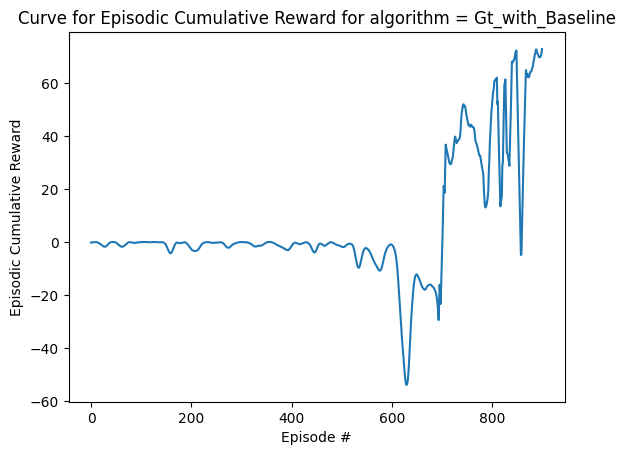

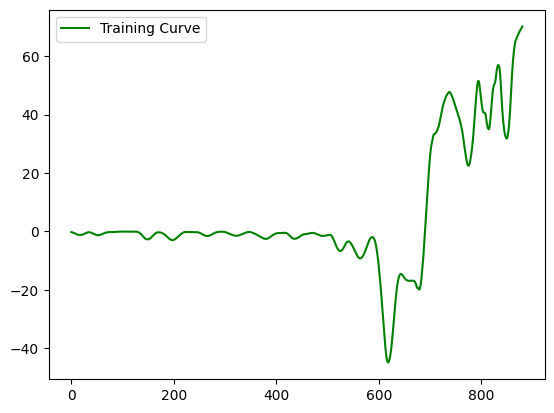

In [14]:
run("Gt_with_Baseline")

In [ ]:
 #For visualization
import gymnasium as gym
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import cv2

In [ ]:
def show_video_of_model(agent, env_name, algo):
    env = gym.make(env_name, render_mode="rgb_array")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(algo+'_trained.mp4', fourcc, 30, (600, 400))
    agent.policy.load_state_dict(torch.load(algo+"_checkpoint1.pth"))
    agent.policy.eval()
    state, _= env.reset()
    done = False
    while not done:
        frame = env.render()
        video.write(frame)
        state_ten = torch.from_numpy(state).float().unsqueeze(0)
        action = agent.policy.select_action(state_ten)[0].detach().numpy()
        action = action.astype(np.float64)
        n_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated 
        state = n_state
    env.close()
    video.release()


In [ ]:
env_type = "MountainCarContinuous-v0"
env = gym.make(env_type)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
plotter_agent = PGAgent(state_dim,action_dim)

show_video_of_model(plotter_agent, "MountainCarContinuous-v0", "Gt")

